In [6]:
import numpy as np

In [7]:
def readFile(file):
    with open(file, encoding='utf8') as f:
        doc = [line.replace('\n','').split('\t') for line in f.readlines()]
    return doc[1:]

In [8]:
train_text = readFile('ratings_train.txt')
test_text = readFile('ratings_test.txt')

In [15]:
len(train_text), len(test_text)

(150000, 50000)

In [14]:
train_text[0][0]

'9976970'

In [19]:
def preprocessing(txt):
    import re
    txt = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', txt)
    sw = set() # 집합자료형 선언
    with open('stopwords-ko.txt', encoding='utf-8') as f:
        for w in f:
            sw.add(w.replace('\n',''))
    doc = []
    from eunjeon import Mecab
    mecab = Mecab()
    for word in mecab.morphs(txt):
        if word not in sw and len(word) > 1:
            doc.append(word)
    return doc

In [20]:
# nsmc 텍스트 토크나이징 함수
def make_token(text):
    pre_data = []
    for row in text:
        r = preprocessing(row[1])
        if r :
            pre_data.append((r,row[2]))
    return pre_data

In [21]:
train_text = make_token(train_text)
test_text = make_token(test_text)

In [22]:
# 형태소추출된 데이터를 pickle 저장
import pickle
with open('train_text.pk', 'wb') as f:
    pickle.dump(train_text, f)
with open('test_text.pk', 'wb') as f:
    pickle.dump(test_text, f)

In [23]:
# pickle 데이터 불러오기
import pickle
with open('train_text.pk', 'rb') as f:
    train = pickle.load(f)
with open('test_text.pk', 'rb') as f:
    test = pickle.load(f)

In [24]:
len(train), len(test)

(146124, 48760)

In [25]:
# import
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
# 파라미터
max_words = 35000
max_len = 50
batch_size=128
epochs = 5

In [27]:
# 데이터 전처리
# 토크나이징, 패딩(제로패딩)
import numpy as np

# 문서만 추출
train_x = [doc for doc, _ in train]

# 토크나이징
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_x)

# 변환(LSTM모델의 입력값을 넣기 위해)
x_train = tokenizer.texts_to_sequences(train_x)
y_train = np.array([int(label) for _, label in train])

x_test = tokenizer.texts_to_sequences([doc for doc, _ in test])
y_test = np.array([int(label) for _, label in test])

# 길이를 동일하게 맞추기
x_train = pad_sequences(x_train, maxlen=max_len, padding='pre')
x_test = pad_sequences(x_test, maxlen=max_len, padding='pre')

# 학습가능한 형태로 변환
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [28]:
train_ds

<BatchDataset shapes: ((None, 50), (None,)), types: (tf.int32, tf.int32)>

In [30]:
# 모델 구현
# 클래스로 구현하는 방법
class MyLSTM(tf.keras.Model):
    # 생성자
    def __init__(self):
        # 부모클래스의 생성자 호출
        super().__init__()
        self.emb = Embedding(max_words, 100)
        self.lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2)
        self.dense = Dense(1, activation='sigmoid')
    
    def call(self, x):
        x = self.emb(x)
        x = self.lstm(x)
        x = self.dense(x)
        return x

In [31]:
# 모델객체 선언
model = MyLSTM()

In [32]:
# 모델설정
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [33]:
# Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, verbose=1)
# ModelCheckpoint
mc = tf.keras.callbacks.ModelCheckpoint('nsmc_bestmodel.cp', monitor='val_loss', mode='min', save_best_only=True)

In [34]:
# 학습
history = model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size, callbacks=[es, mc])

Epoch 1/5
1142/1142 [==============================] - 229s 198ms/step - loss: 0.4694 - acc: 0.7623 - val_loss: 0.3937 - val_acc: 0.8177
Epoch 2/5
1142/1142 [==============================] - 222s 194ms/step - loss: 0.3468 - acc: 0.8463 - val_loss: 0.4008 - val_acc: 0.8188
Epoch 3/5
1142/1142 [==============================] - 225s 197ms/step - loss: 0.2970 - acc: 0.8708 - val_loss: 0.4292 - val_acc: 0.8146
Epoch 4/5
1142/1142 [==============================] - 229s 201ms/step - loss: 0.2481 - acc: 0.8946 - val_loss: 0.4785 - val_acc: 0.8082
Epoch 00004: early stopping


In [35]:
model.evaluate(x_test, y_test)

1524/1524 [==============================] - 14s 9ms/step - loss: 0.4785 - acc: 0.8082


[0.4785158634185791, 0.8081624507904053]

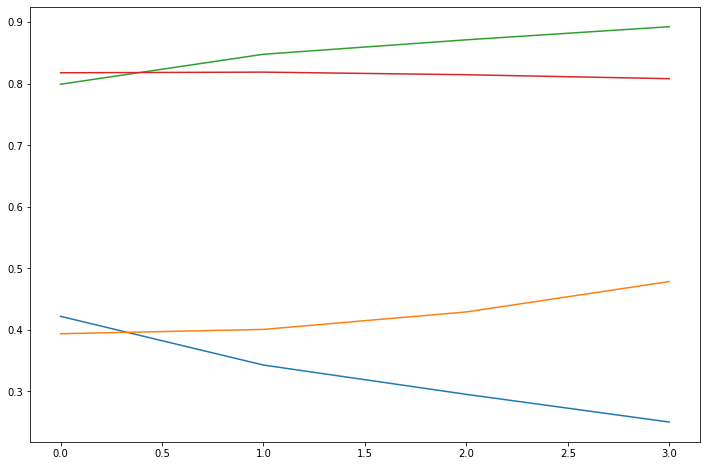

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [59]:
def predict_func(text):
    text = preprocessing(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=max_len, padding='pre')
    print((model.predict(text)))

In [60]:
predict_func('너무 좋아요')

[[0.90556854]]
